# Fitting a mixture model to Praesepe

In [507]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco

In [508]:
# line model
def line(theta, x):
    return np.polyval(theta, x)

# likelihood fn
def lnlike(theta, x, y, yerr):
    Y, V, P, V1 = theta[0], theta[1], theta[2], theta[3]
    pars = theta[4:]
    
    model1 = line(pars, x)
    model2 = Y
    inv_var1 = 1./(V1 + yerr**2)
    inv_var2 = 1./(V + yerr**2)
    lnlike1 =  - 0.5 * ((y-model1)**2*inv_var1 - np.log(inv_var1))
    lnlike2 =  - 0.5 * ((y-model2)**2*inv_var2 - np.log(inv_var2))
    ll = np.sum(np.logaddexp(np.log(1-P) + lnlike1, np.log(P) + lnlike2))

    if P > 0 and P < 1 and V > 0 and V1 > 0:
        return ll
    else:
        return -np.inf

def lnprob(theta, x, y, yerr):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)

Now try with Praesepe data.

In [516]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0
m &= np.log10(pr.bp[m] - pr.rp[m]) < max(np.log10(pr.bp[m] - pr.rp[m]))

logbprp = np.log10(pr.bp[m] - pr.rp[m])
bprp = pr.bp[m] - pr.rp[m]
logp = np.log10(pr.prot[m])

err = .434 * .00001  # 10% uncertainty
logp_err = err * np.ones_like(logp)
log_age = np.ones(len(logp))*np.log10(650*1e6)

m = (bprp < 2.4) * (.8 < bprp) * np.isfinite(logp) * np.isfinite(bprp)
x, y, yerr = bprp[m], logp[m], logp_err[m]

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


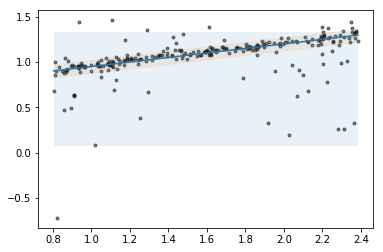

In [517]:
plt.errorbar(x, y, yerr=yerr, fmt = 'k.', alpha=.5, zorder=0)

xp = np.linspace(min(x), max(x), 100)
# Yb, Vb, Pb, V1, m, b
p_init = [.7, .4, .2, .005, .25, .7]
mean = line(p_init[4:], xp)
var = np.sqrt(p_init[1])
var1 = np.sqrt(p_init[3])
Yb = p_init[0]

plt.plot(xp, mean, zorder=1)
plt.fill_between(xp, mean - var1, mean + var1, alpha=.1, color="C1")
plt.fill_between(xp, Yb - var, Yb + var, alpha=.1)

In [518]:
# Calculate maximum-likelihood values
nll = lambda *args: -lnlike(*args)
print(lnlike(p_init, x, y, yerr))
result = sco.minimize(nll, p_init, args=(x, y, yerr))
print(result.x)

431.3914769541827
[0.87075635 0.17594704 0.21318422 0.00105444 0.24604642 0.72001579]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


In [519]:
ndim, nwalkers = len(result.x), 32
pos = [result.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, args=(x, y, yerr));
print("Burn-in")
pos, lp, state = sampler.run_mcmc(pos, 100);
sampler.reset();
print("Full Run")
sampler.run_mcmc(pos, 500);

Burn-in


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log
  


Full Run


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log
  app.launch_new_instance()


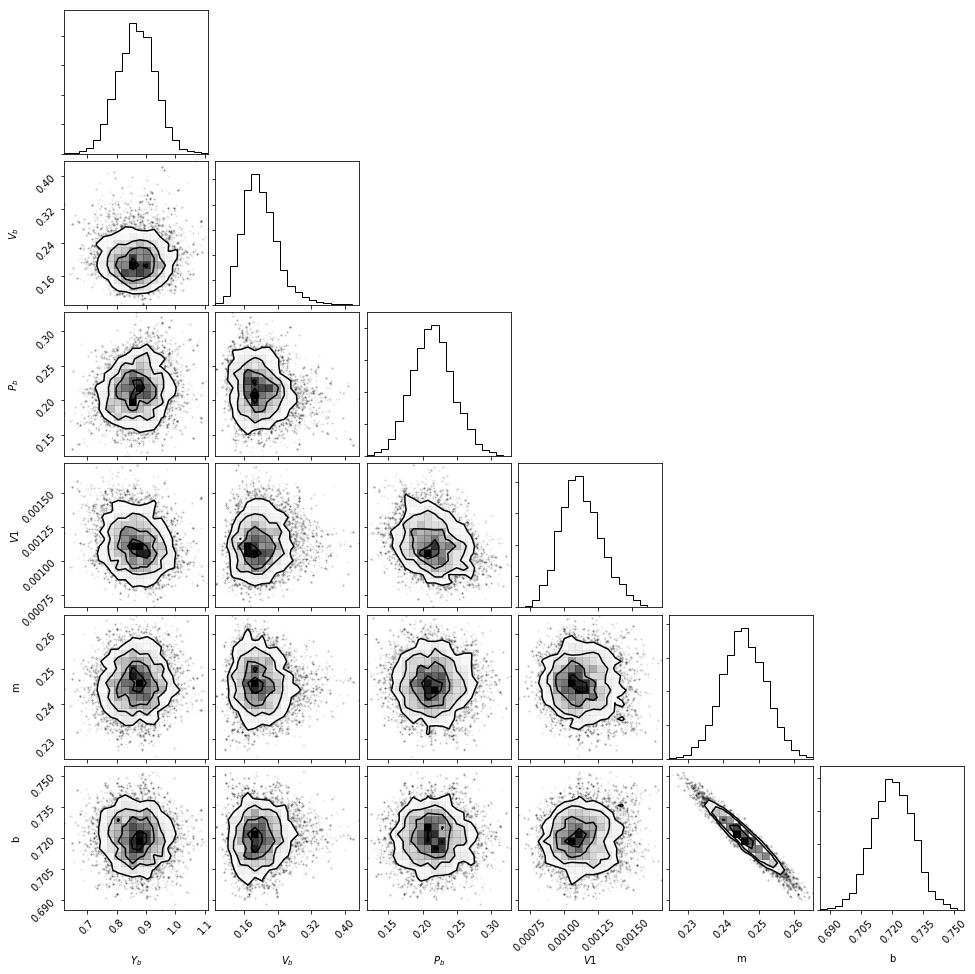

In [520]:
# Flatten chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

# Make triangle plot
fig_labels = ["$Y_b$", "$V_b$", "$P_b$", "$V1$", "m", "b"]
# truths = [Yb_true, Vb_true, Pb_true, V1_true, m_true, b_true]
fig = corner.corner(samples, labels=fig_labels);

[0.86701192 0.19398949 0.21379857 0.00111345 0.24574314 0.72029065]


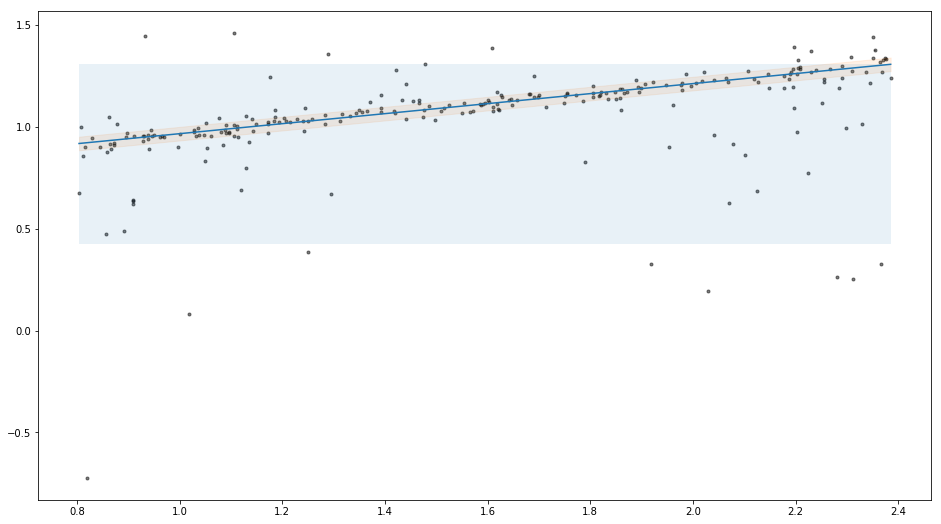

In [521]:
# Yb, Vb, Pb, V1, m, b
mcmc = np.median(samples, axis=0)
print(mcmc)

mean = line(mcmc[4:], xp)
var = np.sqrt(mcmc[1])
var1 = np.sqrt(mcmc[3])
Yb = mcmc[0]

plt.figure(figsize=(16, 9))
plt.errorbar(x, y, yerr=yerr, fmt = 'k.', alpha=.5, zorder=0)
plt.plot(xp, mean, zorder=1)
plt.fill_between(xp, mean - var1, mean + var1, alpha=.1, color="C1")
plt.fill_between(xp, Yb - var, Yb + var, alpha=.1)

So the intrinsic scatter is:

In [537]:
def err_calc(samps):
    med = np.median(samps)
    errp = np.percentile(samps, 84) - med
    errm = med - np.percentile(samps, 16)
    return med, errp, errm

med, errp, errm = err_calc(np.sqrt(samples[:,3])/.434*100)
print(med, errp, errm)

print("{0:.1f} +/- {1:.1f}%".format(med, errp))

7.688569881076765 0.5489692288181178 0.49342775051380006
7.7 +/- 0.5%


Now fit the M dwarfs

/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


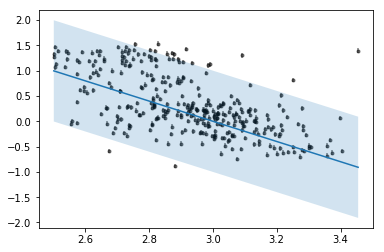

In [502]:
pr = pd.read_csv("data/praesepe.csv")
m = pr.prot > 0

bprp = pr.bp[m] - pr.rp[m]
logp = np.log10(pr.prot[m])

m = (bprp > 2.5) * np.isfinite(logp) * np.isfinite(bprp)
xm, ym = bprp[m], logp[m]

err = .434 * .1  # 10% uncertainty
yerrm = err * np.ones(len(xm))

xplot = np.linspace(min(xm), max(xm), 100)
plt.errorbar(xm, ym, yerr=yerrm, fmt = 'k.', alpha=.5, zorder=0)
p_initm = [1., -2, 6.]
plt.plot(xplot, line(p_initm[1:], xplot))
plt.fill_between(xplot, line(p_initm[1:], xplot) - np.sqrt(p_initm[0]), 
                 line(p_initm[1:], xplot) + np.sqrt(p_initm[0]), alpha=.2)

In [503]:
# likelihood fn
def lnlikem(theta, x, y, yerr):
    V = theta[0]
    pars = theta[1:]
    
    model = line(pars, x)
    ivar = 1./(V + yerr**2)
    lnlike =  - 0.5 * ((y - model)**2*ivar - np.log(ivar))
    ll = np.sum(lnlike)

    if V > 0:
        return ll
    else:
        return -np.inf
    
# likelihood fn
def lnlikeh(theta, x, y, yerr):
    model = line(theta, x)
    ivar = 1./yerr**2
    lnlike =  - 0.5 * ((y - model)**2*ivar - np.log(ivar))
    return np.sum(lnlike)

In [504]:
# Calculate maximum-likelihood values
nllm = lambda *args: -lnlikem(*args)
nllh = lambda *args: -lnlikeh(*args)

resultm = sco.minimize(nllm, p_initm, args=(xm, ym, yerrm))
print(resultm.x)

[ 0.21495259 -1.7825264   5.53230536]


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  


0.4636298037625031


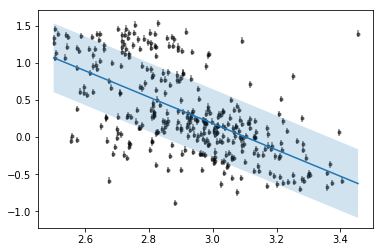

In [506]:
varm = np.sqrt(resultm.x[0])
plt.errorbar(xm, ym, yerr=yerrm, fmt = 'k.', alpha=.5, zorder=0)
plt.plot(xplot, line(resultm.x[1:], xplot))
plt.fill_between(xplot, line(resultm.x[1:], xplot) - varm, 
                 line(resultm.x[1:], xplot)+ varm, alpha=.2)
print(varm)

Now fit the hot stars.

In [354]:
m = (bprp < .8) * np.isfinite(logp) * np.isfinite(bprp)
xh, yh = bprp[m], logp[m]

err = .434 * .1  # 10% uncertainty
yerrh = err * np.ones(len(xh))

p_inith = [1., 1., 1.]
resulth = sco.minimize(nllh, p_inith, args=(xh, yh, yerrh))
print(resulth.x)

[-17.62672985  28.30450331 -10.53172402]


/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


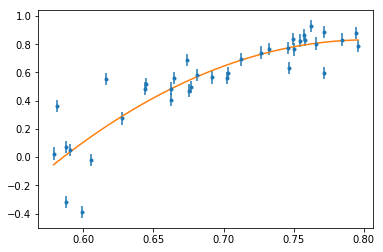

In [355]:
plt.errorbar(xh, yh, yerr=yerrh, fmt=".")
xph = np.linspace(min(xh), max(xh), 100)
plt.plot(xph, line(resulth.x, xph))

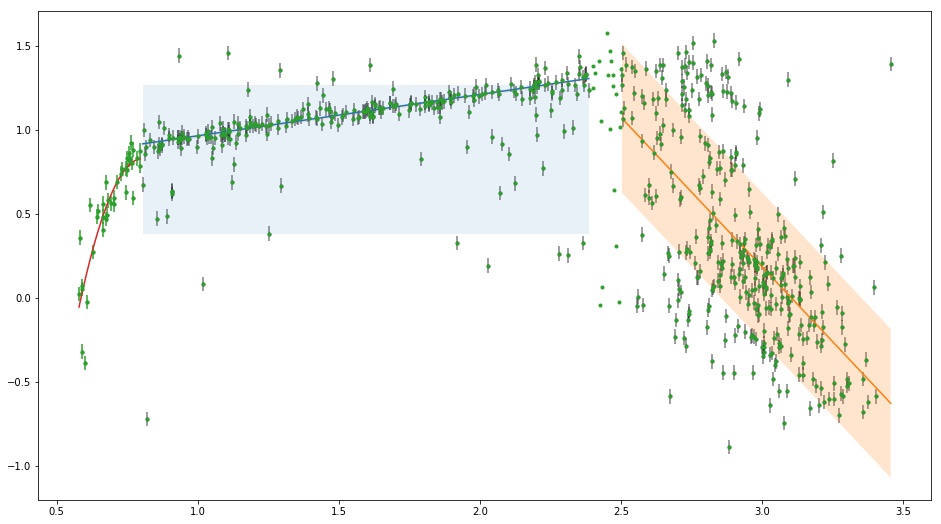

In [356]:
plt.figure(figsize=(16, 9))
plt.errorbar(x, y, yerr=yerr, fmt = 'k.', alpha=.5, zorder=0)
plt.plot(xp, mean, zorder=1)
plt.fill_between(xp, mean - var1, mean + var1, alpha=.1, color="C1")
plt.fill_between(xp, Yb - var, Yb + var, alpha=.1)

plt.errorbar(xm, ym, yerr=yerrm, fmt = 'k.', alpha=.5, zorder=0)
plt.plot(xplot, resultm.x[1]*xplot + resultm.x[2])
plt.fill_between(xplot, resultm.x[1]*xplot + resultm.x[2] - var, 
                 resultm.x[1]*xplot + resultm.x[2] + var, alpha=.2)

plt.plot(pr.bp - pr.rp, np.log10(pr.prot), ".")

plt.errorbar(xh, yh, yerr=yerrh, fmt=".", color="C2")
plt.plot(xph, line(resulth.x, xph))

Now put it all together...

100


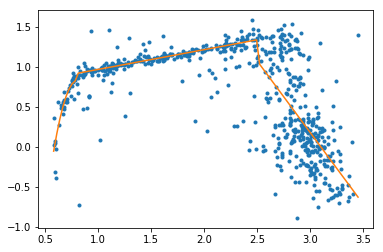

In [430]:
plt.plot(pr.bp - pr.rp, np.log10(pr.prot), ".")
xs = np.linspace(min(pr.bp-pr.rp), max(pr.bp-pr.rp), 100)

# 0, 1, 2,  3,  4,  5,  6,  7, 8,  9,  10, 11
# m, b, mm, mb, mh, bh, ch, V, Vm, Pb, Yb, Vb
par_init = [mcmc[4], mcmc[5], resultm.x[1], resultm.x[2], resulth.x[0], 
            resulth.x[1], resulth.x[2], mcmc[3], resultm.x[0], mcmc[0], mcmc[1], mcmc[2]]
log_periods = model(par_init, xs)
print(len(log_periods))
plt.plot(xs, model(par_init, xs))

In [477]:
def model(p, x, br1=.8, br2=2.6):
    logp = np.zeros(len(x))
    hot = x < br1
    cool = x >= br2
    warm = (x > br1) * (x <= br2)
    logp[warm] = np.polyval(p[:2], x[warm])
    logp[cool] = np.polyval(p[2:4], x[cool])
    logp[hot] = np.polyval(p[4:7], x[hot])
    
#     real_hot = x < .56
#     logp[real_hot] = np.ones(len(x[real_hot]))*0.56  # std = 0.38

    return logp


def tot_lnlike(p, x, y, yerr, br1=.8, br2=2.6):
    m, b, mm, mb, mh, bh, ch, V, Vm, Pb, Yb, Vb = p
    
    hot = x < br1
    cool = x >= br2
    warm = (x > br1) * (x <= br2)
        
    ivar_warm = 1./(V + yerr[warm]**2)
    ivar_cool = 1./(Vm + yerr[cool]**2)
    ivar_hot = 1./(V + yerr[hot]**2)
    warm_lnlike = -.5 * ((y[warm] - model(p, x[warm]))**2*ivar_warm - np.log(ivar_warm))
    cool_lnlike = -.5 * ((y[cool] - model(p, x[cool]))**2*ivar_cool - np.log(ivar_cool))
    hot_lnlike = -.5 * ((y[hot] - model(p, x[hot]))**2*ivar_hot - np.log(ivar_hot))
    ll = np.sum(warm_lnlike) + np.sum(cool_lnlike) + np.sum(hot_lnlike)
    
    # The binary mixture model likelihood.
    ivar_b = 1./(Vb + yerr**2)
    b_lnlike =  - 0.5 * ((y - Yb)**2*ivar_b - np.log(ivar_b))
    ll_b = np.sum(np.logaddexp(np.log(1-Pb) + ll, np.log(Pb) + b_lnlike))
    
    if V < 0 or Vm < 0 or Vb < 0 or Pb > 1 or Pb < 0:
        return -np.inf
    else:
        return ll_b

nll_tot = lambda *args: -tot_lnlike(*args)

In [478]:
print(tot_lnlike(par_init, x_tot, y_tot, yerr_tot))

-505.6559812076299


/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


In [479]:
x_tot, y_tot = bprp, logp

err = .434 * .1  # 10% uncertainty
yerr_tot = err * np.ones(len(x_tot))
result_tot = sco.minimize(nll_tot, par_init, args=(x_tot, y_tot, yerr_tot))

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the

In [480]:
print(par_init)
print(result_tot.x)

[0.246141605357876, 0.7210060867821884, -1.782526395232327, 5.532305360386226, -17.62672984908566, 28.304503305317375, -10.53172401545041, 4.8790699174918285e-05, 0.21495259493685714, 0.8264393011644429, 0.1962360758934833, 0.18702495608295933]
[ 2.46141605e-01  7.21006087e-01 -1.78252640e+00  5.53230536e+00
 -1.76267298e+01  2.83045033e+01 -1.05317240e+01  4.87906992e-05
  2.14952595e-01  9.37022010e-01  4.09528603e-01  6.31212712e-01]


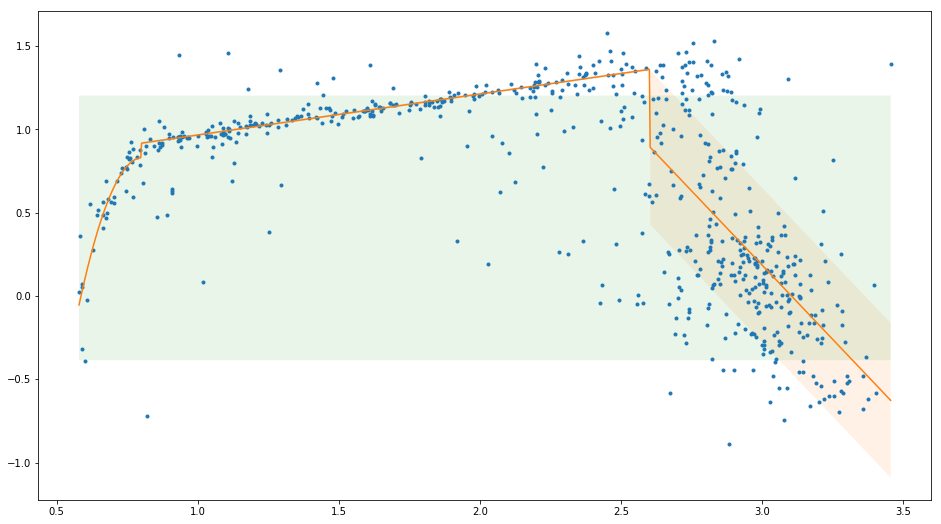

In [481]:
br2 = 2.6

plt.figure(figsize=(16, 9))
plt.plot(pr.bp - pr.rp, np.log10(pr.prot), ".")
xs = np.linspace(min(pr.bp-pr.rp), max(pr.bp-pr.rp), 1000)

log_periods = model(result_tot.x, xs)
plt.plot(xs, log_periods)

var1 = np.sqrt(result_tot.x[7])
var2 = np.sqrt(result_tot.x[8])
plt.fill_between(xs[xs < br2], model(result_tot.x, xs[xs < br2]) - var1,
                 model(result_tot.x, xs[xs < br2]) + var1, alpha=.1)

plt.fill_between(xs[xs > br2], model(result_tot.x, xs[xs > br2]) - var2,
                 model(result_tot.x, xs[xs > br2]) + var2, alpha=.1)

var_b = np.sqrt(result_tot.x[11])
plt.fill_between(xs, np.ones_like(xs)*result_tot.x[10] - var_b, 
                 np.ones_like(xs)*result_tot.x[10] + var_b, alpha=.1)

Next I could try
1) Fitting the sigmoid function.
2) Adding the Sun (and other Solar calibrators?
3) Having the breaks be free parameters?

In [476]:
# 0, 1, 2,  3,  4,  5,  6,  7, 8,  9,  10, 11
# m, b, mm, mb, mh, bh, ch, V, Vm, Pb, Yb, Vb

print(result_tot.x)
print("Pb = ", result_tot.x[9])
print("V = ", result_tot.x[7])

[ 2.46141605e-01  7.21006087e-01 -1.78252640e+00  5.53230536e+00
 -1.76267298e+01  2.83045033e+01 -1.05317240e+01  4.87906992e-05
  2.14952595e-01  9.37022010e-01  4.09528603e-01  6.31212712e-01]
Pb =  0.9370220098215256
V =  4.8790699174918285e-05


In [457]:
ndim, nwalkers = len(result_tot.x), 32
pos = [result_tot.x + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, tot_lnlike, args=(x_tot, y_tot, yerr_tot));
print("Burn-in")
pos, lp, state = sampler.run_mcmc(pos, 100);
sampler.reset();
print("Full Run")
sampler.run_mcmc(pos, 500);

Burn-in


/anaconda3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:180: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))
/anaconda3/lib/python3.7/site-packages/emcee-3.0rc2-py3.7.egg/emcee/moves/red_blue.py:97: RuntimeWarning: invalid value encountered in double_scalars
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in log
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in log


Full Run


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in log


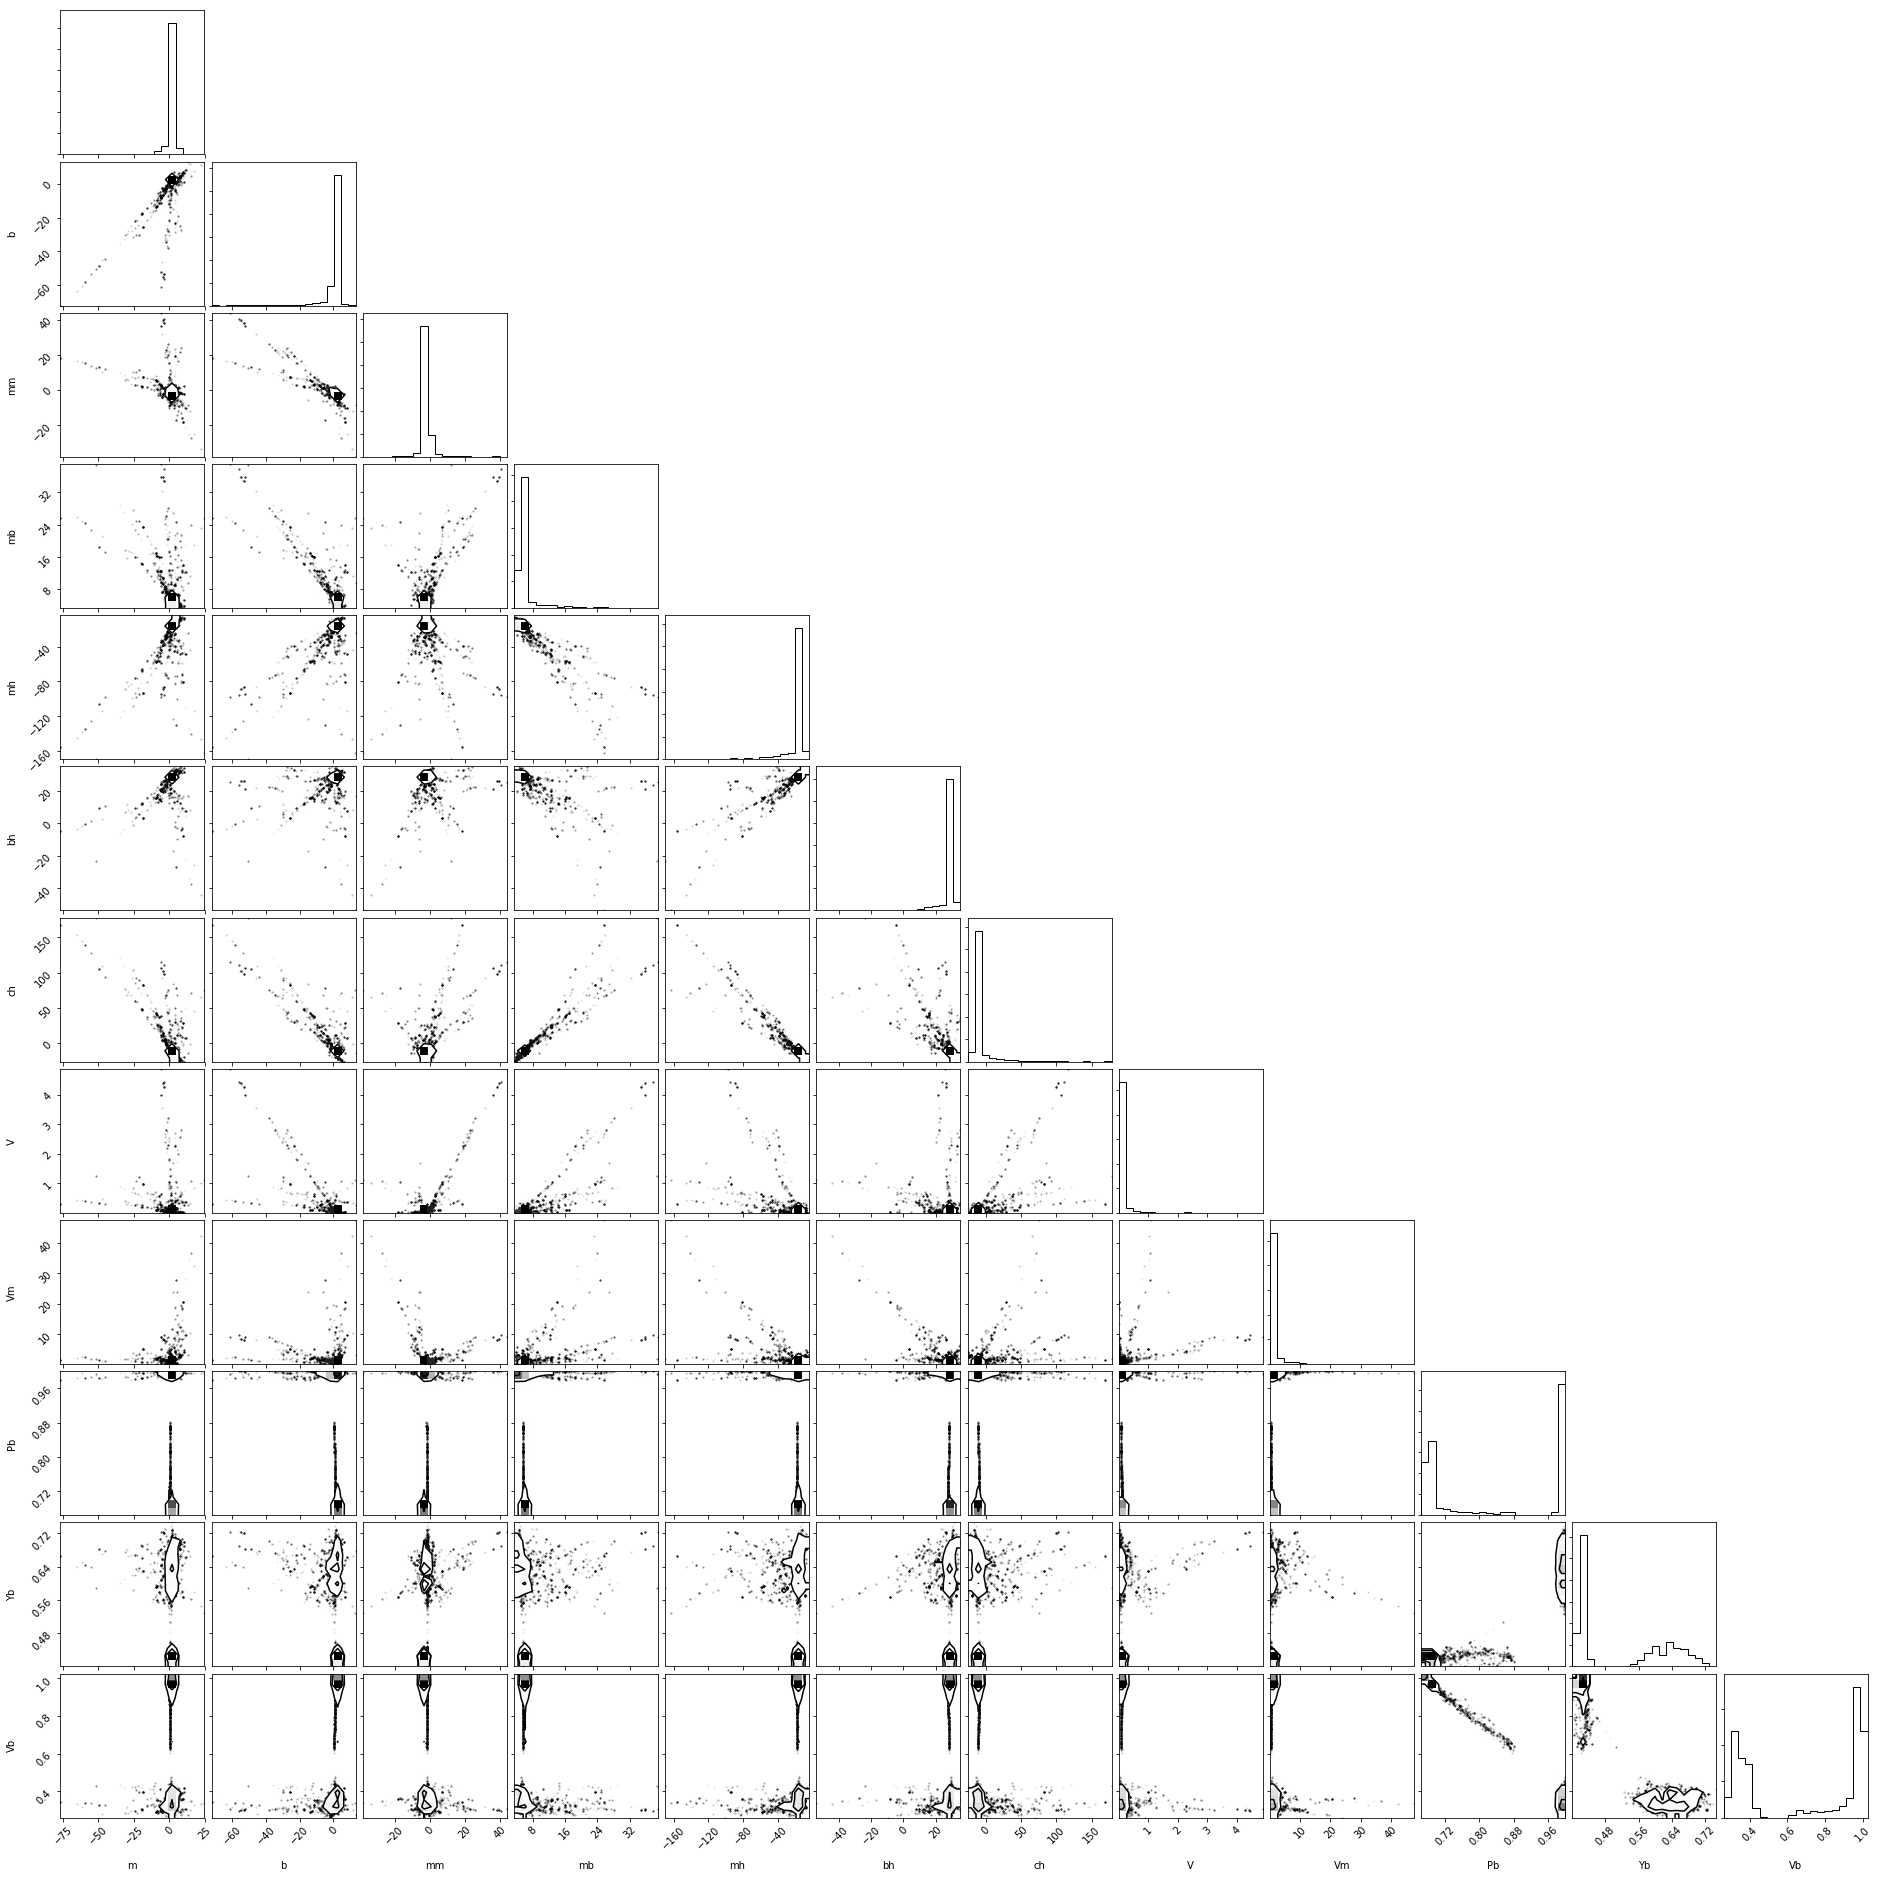

In [458]:
# Flatten chain
samples = sampler.chain[:, 50:, :].reshape((-1, ndim))

# Make triangle plot
fig_labels = ["m", "b", "mm", "mb", "mh", "bh", "ch", "V", "Vm", "Pb", "Yb", "Vb"]
fig = corner.corner(samples, labels=fig_labels);

In [459]:
mcmc_tot = np.median(samples, axis=0)
print(mcmc_tot)
print("Pb = ", mcmc_tot[9])
print("V = ", mcmc_tot[7])

[  0.03723866   0.95806044  -1.78732686   5.57037909 -18.31447652
  27.85237607  -9.88247967   0.09878958   0.20973927   0.77393524
   0.42818978   0.81001606]
Pb =  0.7739352431235913
V =  0.09878957663114663
